<a href="https://colab.research.google.com/github/DamoNeer/IDS/blob/main/detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
pip install pandas numpy plotly sklearn matplotlib imblearn

In [27]:
import os 
import warnings
import gc
import pandas as pd 
import numpy as np 
import plotly.graph_objects as go

import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn


In [46]:
warnings.simplefilter('ignore')
pd.set_option('max_columns', 50)

train = pd.read_csv("Train_data.csv")
test = pd.read_csv("Test_data.csv")

X, y = train.iloc[:, :-1], train['class']
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, random_state = seed)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

display(train)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,18,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [47]:
categorical_features = ['protocol_type', 'service', 'flag']
for f in categorical_features:
    val_counts = X_train[f].value_counts()
    fig = go.Figure()
    fig.add_trace(go.Pie(
        labels=val_counts.index,
        values=val_counts
    ))
    fig.update_traces(textposition='inside') 
    fig.update_layout(
        title=f"Pie Chart of {f}")
    fig.show()

In [29]:
#Scale transform numerical values and convert back to dataframe object

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cols = train.select_dtypes(include=['float64', 'int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64', 'int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64', 'int64']))

sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

#Encoding categorical values

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
category_train = train.select_dtypes(include=['object']).copy()
category_test = test.select_dtypes(include=['object']).copy()
train_category = category_train.apply(encoder.fit_transform)
test_category = category_test.apply(encoder.fit_transform)
enctrain = train_category.drop(['class'], axis = 1)
cat_Ytrain = train_category[['class']].copy()

In [30]:
train_x = pd.concat([sc_traindf, enctrain], axis = 1)
train_y = train['class']
test_df = pd.concat([sc_testdf, test_category], axis = 1)

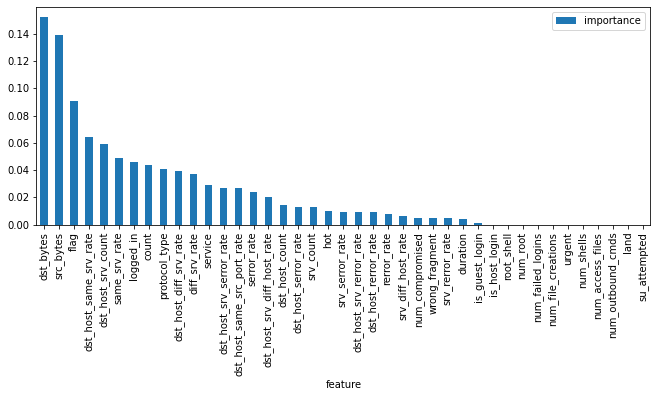

In [32]:
#Prioritizing features and plotting how important each feature is

rfc = RandomForestClassifier()
rfc.fit(train_x, train_y)
score = np.round(rfc.feature_importances_, 3)
importances = pd.DataFrame({'feature': train_x.columns, 'importance': score})
importances = importances.sort_values('importance', ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (11,4)
importances.plot.bar()

from sklearn.feature_selection import RFE
import itertools

rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)
feature_map = [(i,v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i , v in feature_map if i == True]

In [34]:
# Splitting the dataset

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, train_size=0.70, random_state=2)

In [ ]:
# Model fit

from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train)

#Bernoulli Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

#Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

In [38]:
# Model Evaluation

from sklearn import metrics

models = []
models.append(('Bernoulli Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

for i, v in models:
  scores = cross_val_score(v, X_train, Y_train, cv=10)
  accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
  confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
  classification = metrics.classification_report(Y_train, v.predict(X_train))
  print()
  print('============================== {} Model Evaluation =============================='.format(i))
  print()
  print ("Cross Validation Mean Score:" "\n", scores.mean())
  print()
  print ("Model Accuracy:" "\n", accuracy)
  print()
  print("Confusion matrix:" "\n", confusion_matrix)
  print()
  print("Classification report:" "\n", classification) 
  print()



============================== Bernoulli Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9071666840303904

Model Accuracy:
 0.9071679709651809

Confusion matrix:
 [[7000 1245]
 [ 392 8997]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.95      0.85      0.90      8245
      normal       0.88      0.96      0.92      9389

    accuracy                           0.91     17634
   macro avg       0.91      0.90      0.91     17634
weighted avg       0.91      0.91      0.91     17634



============================== Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9956333771928133

Model Accuracy:
 1.0

Confusion matrix:
 [[8245    0]
 [   0 9389]]

Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8245
      normal       1.00      1.00      1.00

In [39]:
# Prediction

for i, v in models:
  accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
  confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
  classification = metrics.classification_report(Y_test, v.predict(X_test))
  print()
  print('============================== {} Model Test Results =============================='.format(i))
  print()
  print ("Model Accuracy:" "\n", accuracy)
  print()
  print("Confusion matrix:" "\n", confusion_matrix)
  print()
  print("Classification report:" "\n", classification) 
  print()

pred_NB = BNB_Classifier.predict(test_df)
pred_log = LGR_Classifier.predict(test_df)
pred_dt = DTC_Classifier.predict(test_df)


============================== Bernoulli Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.906721354855782

Confusion matrix:
 [[2981  517]
 [ 188 3872]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.94      0.85      0.89      3498
      normal       0.88      0.95      0.92      4060

    accuracy                           0.91      7558
   macro avg       0.91      0.90      0.91      7558
weighted avg       0.91      0.91      0.91      7558



============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9949722148716592

Confusion matrix:
 [[3482   16]
 [  22 4038]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.99      1.00      0.99      3498
      normal       1.00      0.99      1.00      4060

    accuracy                           0.99      7558
   macro avg    

In [42]:
# (True|False)(Positive|Negative)

def perf_measure(y_actual, y_pred):
  TP, FP, TN, FN = 0,0,0,0
  for i in range(len(y_pred)):
    if y_actual.iat[i] == y_pred[i] == 'anomaly':
      TP += 1
    if y_pred [i] == 'anomaly' and y_actual.iat[i] != y_pred[i]:
      FP += 1
    if y_actual.iat[i] == y_pred[i] == 'normal':
      TN += 1
    if y_pred[i] == 'normal' and y_actual.iat[i] != y_pred[i]:
      FN += 1
  return (TP, FP, TN, FN)

for i, v in models:
  print("For model:", i)
  TP, FP, TN, FN = perf_measure(Y_test, v.predict(X_test))
  print ("TP:", TP, "\tFP:", FP, "\t\tTN:", TN, "\tFN:", FN)

For model: Bernoulli Naive Baye Classifier
TP: 2981 	FP: 188 		TN: 3872 	FN: 517
For model: Decision Tree Classifier
TP: 3482 	FP: 22 		TN: 4038 	FN: 16
For model: LogisticRegression
TP: 3296 	FP: 138 		TN: 3922 	FN: 202


In [45]:
# Prediction for second row

for i,v in models:
  print("For model: ", i)
  print ("Expected: ", Y_test.iloc[1], "\tPredicted: ", v.predict(X_test).reshape(1, -1)[0][1] )
  print()

For model:  Bernoulli Naive Baye Classifier
Expected:  anomaly 	Predicted:  anomaly

For model:  Decision Tree Classifier
Expected:  anomaly 	Predicted:  anomaly

For model:  LogisticRegression
Expected:  anomaly 	Predicted:  anomaly

